In [1]:
import colorama
colorama.init()
from colorama import Fore, Style, Back

In [2]:
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [3]:
with open('intents.json') as file:
    data = json.load(file)

training_sentences = []
training_labels = []
labels = []
responses = []


for intent in data['intents']:
    for pattern in intent['patterns']:
        training_sentences.append(pattern)
        training_labels.append(intent['tag'])
    responses.append(intent['responses'])

    if intent['tag'] not in labels:
        labels.append(intent['tag'])

num_classes = len(labels)

In [4]:
lbl_encoder = LabelEncoder()
lbl_encoder.fit(training_labels)
training_labels = lbl_encoder.transform(training_labels)

In [5]:
vocab_size = 1000
embedding_dim = 16
max_len = 20
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_len)

In [6]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()
epochs = 500
history = model.fit(padded_sequences, np.array(training_labels), epochs=epochs)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 16)            16000     
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 33)                561       
                                                                 
Total params: 17105 (66.82 KB)
Trainable params: 17105 (66.82 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

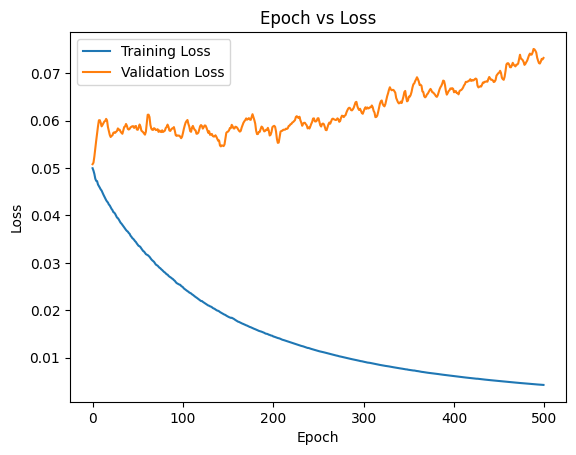

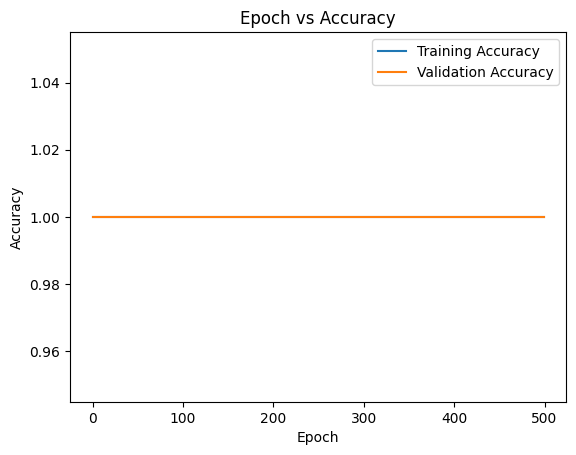

1/1 [==============================] - 0s 120ms/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, training_labels, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=0)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred = np.argmax(model.predict(X_test), axis=-1)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)


In [8]:
model.save("chat_model")
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('label_encoder.pickle', 'wb') as ecn_file:

    pickle.dump(lbl_encoder, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: chat_model\assets


INFO:tensorflow:Assets written to: chat_model\assets


In [ ]:
import json
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder

import colorama
colorama.init()
from colorama import Fore, Style, Back

import random
import pickle

with open("intents.json") as file:
    data = json.load(file)


def chat():
    # load trained model
    model = keras.models.load_model('chat_model')

    # load tokenizer object
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    # load label encoder object
    with open('label_encoder.pickle', 'rb') as enc:
        lbl_encoder = pickle.load(enc)

    # parameters
    max_len = 20

    while True:
        print(Fore.LIGHTBLUE_EX + "User: " + Style.RESET_ALL, end="")
        inp = input()
        if inp.lower() == "quit":
            break

        result = model.predict(keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([inp]),
                                             truncating='post', maxlen=max_len))
        tag = lbl_encoder.inverse_transform([np.argmax(result)])

        for i in data['intents']:
            if i['tag'] == tag:
                print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL , np.random.choice(i['responses']))

print(Fore.YELLOW + "Start messaging with the bot (type quit to stop)!" + Style.RESET_ALL)
chat()

Start messaging with the bot (type quit to stop)!
User: 

 hello


1/1 [==============================] - 0s 52ms/step
ChatBot: Hi
User: 

 what is your name?


1/1 [==============================] - 0s 17ms/step
ChatBot: I'm Friday!
User: 

 Who are you?


1/1 [==============================] - 0s 18ms/step
ChatBot: Im Friday, your bot assistant
User: 

 what are the places to visit in manipal?


1/1 [==============================] - 0s 17ms/step
ChatBot: Beaches: Malpe,Mattu,Kodi Bengde,kapu
User: 

 do restaurants and cafes in manipal offer delivery services?


1/1 [==============================] - 0s 18ms/step
ChatBot: Yes, many restaurants and cafes in Manipal offer delivery services. You can either order directly from the establishment or use third-party food delivery apps like Swiggy or Zomato to get your favorite food delivered to your doorstep.
User: 

 Is there any entry fee for visiting attractions in manipal?


1/1 [==============================] - 0s 18ms/step
ChatBot: Entry fees may apply to some tourist attractions in Manipal, while others may be free to visit. The entry fee, if applicable, varies for each attraction. It's recommended to inquire about entry fees beforehand or check the official website of the attraction.
User: 

 Medical stores in manipal?


1/1 [==============================] - 0s 16ms/step
ChatBot: There are numerous pharmacies and medical stores located across Manipal, ensuring easy access to medicines and healthcare products. Some well-known pharmacies include Apollo Pharmacy, Manipal Pharmacy, and Guardian Pharmacy.
User: 